# Drainage Area Delineation

In [1]:
from __future__ import annotations

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import shapely

import pygeohydro as gh
import pynhd
from pynhd import GeoConnex

In this tutorial, we obtain upstream drainage areas of all USGS gages included in the CAMELS dataset using NHDPlus V2 catchments. First, we use `pynhd.enhd_flowlines_nx` to obtain the CONUS drainage network based on the [ENHD](https://www.sciencebase.gov/catalog/item/63cb311ed34e06fef14f40a3). This function returns a `networkx.DiGraph` object, a mapping from the node IDs of the generated network to ComIDs of ENHD, and a list of topologically sorted ComIDs. Note that for performance reasons, the node IDs of the generated network are different than the ComIDs of ENHD. Then, we obtain NHDPlus V2 catchments using `pynhd.nhdplus_l48`. Note that this function requires `py7zr` as a dependency. Finally, we navigate the ENHD network to find catchments that are upstream of each gage and compare the drainage areas obtained from this method with that of the original CAMELS dataset.

In [2]:
graph, node2comid, _ = pynhd.enhd_flowlines_nx()
comid2node = {v: k for k, v in node2comid.items()}
conus_cat = pynhd.nhdplus_l48("CatchmentSP")

The NHDPlus V2 catchments are MultiPloygon geometries even if they are a single polygon. So, we convert the the single-polygon geometries to Polygon geometries. We also set the index of this GeoDataFrame to the ComID of the catchment, which is called `FEATUREID`.

In [3]:
conus_cat = conus_cat.set_index("FEATUREID")
single_poly = shapely.get_num_geometries(conus_cat.geometry) == 1
conus_cat.loc[single_poly, "geometry"] = shapely.get_geometry(
    conus_cat.loc[single_poly, "geometry"], 0
)

Next, we get the gage stations of the CAMELS dataset using `pygeohydro.get_camels`.

In [4]:
basins, attrs = gh.get_camels()

For navigating the ENHD network, we need to find the ComIDs that are associated with the gages. FOr this purpose, we use the GeoConnex web service.

In [5]:
gcx = GeoConnex("gages")
gages = gcx.byid("provider_id", basins.index)

Considering that not all stations have an associated ComID, we filter the gages to only include those that have a ComID.

In [6]:
gages = gages[~gages["nhdpv2_comid"].isnull()].set_index("provider_id").copy()
gages["nhdpv2_comid"] = gages["nhdpv2_comid"].astype(int)

Since nodes of the ENHD network are not the same as ComIDs, we add a new column to the filtered gages GeoDataFrame and exclude the gages that their ComIDs are not in the ENHD network. Note that ENHD network does not include all NHDPlus V2 flowlines since all divergences are removed, to convert the NHDPlus V2 network to a dendritic structure.


In [7]:
gages["node"] = gages["nhdpv2_comid"].map(comid2node.get)
gages = gages[~gages["node"].isnull()].copy()

Finally, we use `networkx.ancestors` to find the upstream nodes of each gage and then we use the ComIDs of these nodes to find the catchments that are upstream of each gage.

In [8]:
def _union_catchments(node: int) -> shapely.Polygon | shapely.MultiPolygon:
    """Union the catchments of the given list of ComIDs."""
    id_list = [node2comid[node], *[node2comid[i] for i in nx.ancestors(graph, node)]]
    id_list = conus_cat.index.intersection(id_list)
    if len(id_list) == 0:
        return shapely.Polygon()
    poly = conus_cat.loc[id_list, "geometry"].union_all()
    if shapely.get_type_id(poly) == 3:
        return shapely.Polygon(poly.exterior)
    return shapely.MultiPolygon([shapely.Polygon(p.exterior) for p in poly.geoms])


gages_catchments = gpd.GeoDataFrame(
    geometry=[_union_catchments(node) for node in gages["node"]],
    index=gages.index,
    crs=conus_cat.crs,
)

Let's plot the biases of the drainage areas obtained from the ENHD network and the original CAMELS dataset.

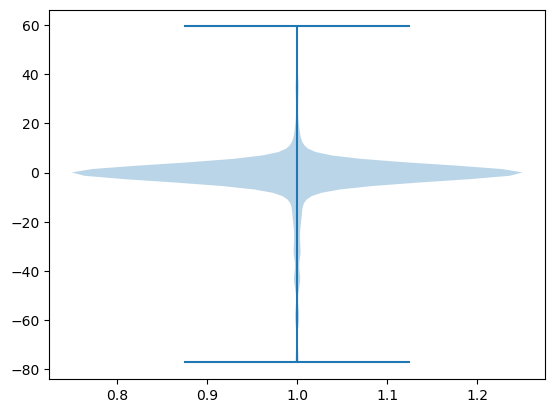

In [9]:
gages_catchments["nhdv1_areaskqm"] = basins.loc[gages_catchments.index].to_crs(5070).area * 1e-6
gages_catchments["nhdv2_areaskqm"] = gages_catchments.to_crs(5070).area * 1e-6
bias = gages_catchments["nhdv2_areaskqm"] - gages_catchments["nhdv1_areaskqm"]
vmax = bias.abs().quantile(0.95)
_ = plt.violinplot(bias[(bias > -vmax) & (bias < vmax)], showextrema=True)
plt.savefig("_static/gages_catchments_bias.png", dpi=90)

We notice that biases are between -20 and 20 sqkm. We can also produce an interactive plot of the upstream drainage areas using `folium`.

```python
from folium import GeoJson

m = gages_catchments.explore()
GeoJson(
    basins,
    style_function=lambda _: {"color": "red", "weight": 1, "fillOpacity": 0.1},
).add_to(m)
m
```